In [1149]:
# --- IMPORTAÇÃO DAS BIBLIOTECAS ---

import numpy as np
import matplotlib.pyplot as plt

# Funções específicas do scikit-image
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.feature import canny

# Importações específicas para a Transformada de Hough (Detectar Círculos)
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

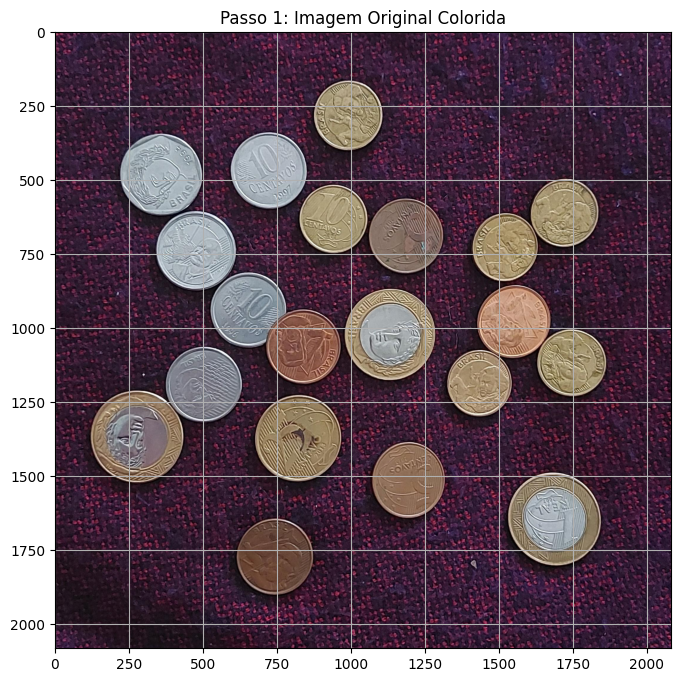

In [1150]:
# --- CARREGAR A IMAGEM ---

caminho_arquivo = '../images/coin_01.jpg'

imagem_original = imread(caminho_arquivo)

plt.figure(figsize=(8, 8))
plt.imshow(imagem_original)
plt.title("Passo 1: Imagem Original Colorida")
plt.grid(True)
plt.show()

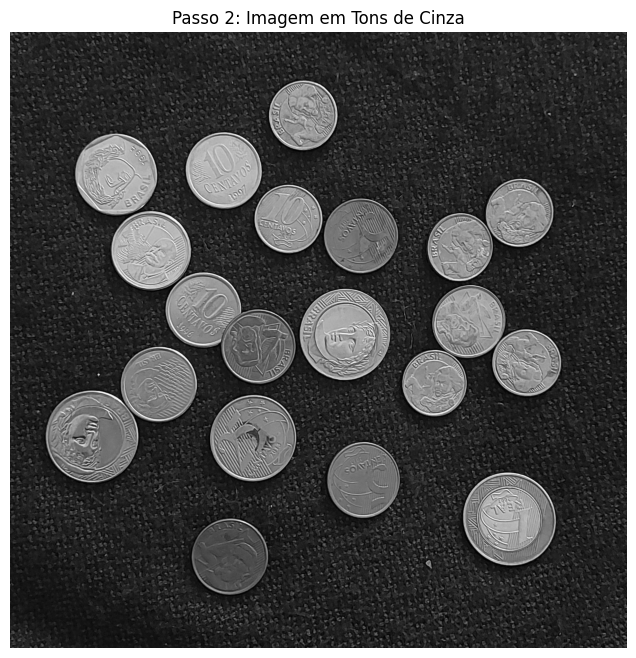

In [1151]:
# --- CONVERSÃO PARA TONS DE CINZA ---

# A função rgb2gray converte a imagem para uma matriz 2D
# O resultado varia de 0.0 (preto absoluto) a 1.0 (branco absoluto)
imagem_cinza = rgb2gray(imagem_original)
imagem_cinza_uint8 = (imagem_cinza * 255).astype(np.uint8)

# Visualizando
plt.figure(figsize=(8, 8))
plt.imshow(imagem_cinza_uint8, cmap='gray')
plt.title("Passo 2: Imagem em Tons de Cinza")
plt.axis('off')
plt.show()

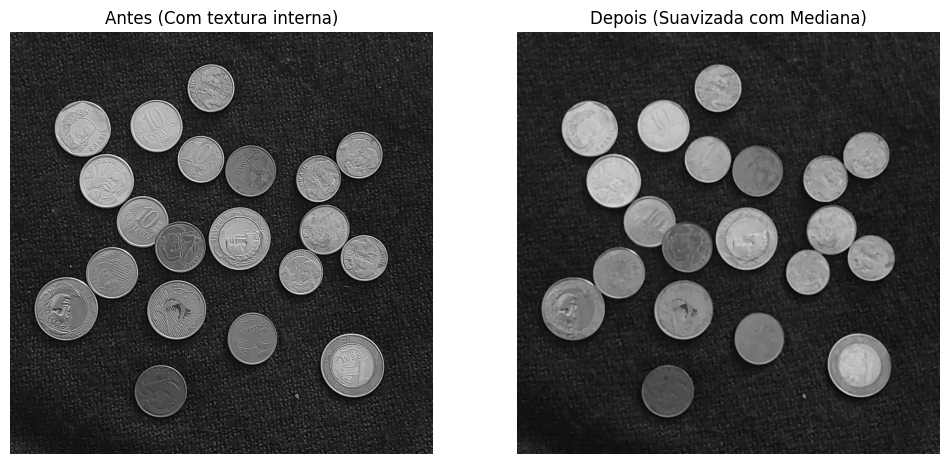

In [1152]:
# --- FILTRAGEM DE RUÍDO (MEDIANA) ---

# Criamos um "elemento estruturante" em forma de disco.
# O número dentro do disk significa o tamanho do raio de um círculo em pixels.
# O filtro vai olhar vizinhanças desse tamanho e pegar o valor do meio (mediana).
elemento_disco = disk(7) 

# Aplicamos o filtro na imagem cinza
imagem_filtrada = median(imagem_cinza_uint8, elemento_disco)

# Visualizando a diferença
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(imagem_cinza_uint8, cmap='gray')
plt.title("Antes (Com textura interna)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagem_filtrada, cmap='gray')
plt.title("Depois (Suavizada com Mediana)")
plt.axis('off')

plt.show()

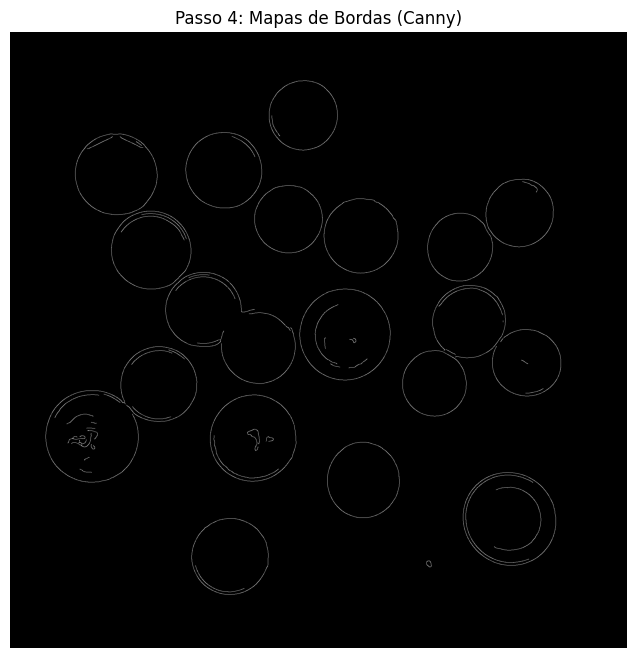

In [1153]:
# --- DETECÇÃO DE BORDAS (CANNY) ---

# O parâmetro 'sigma' controla a suavização.
# sigma=3 é focado em pegar apenas contornos (as moedas).
# Se colocar sigma=1, ele pega qualquer risco.
bordas_canny = canny(imagem_filtrada, sigma=3)

# O resultado é uma imagem binária (True/False): True onde tem borda, False onde é liso.

# Visualizando
plt.figure(figsize=(8, 8))
# Mostramos em fundo preto (gray) onde o branco é a borda
plt.imshow(bordas_canny, cmap='gray') 
plt.title("Passo 4: Mapas de Bordas (Canny)")
plt.axis('off')
plt.show()

In [1154]:
# --- TRANSFORMADA DE HOUGH (CALCULAR CENTROS) ---

# 1. Definir o que estamos procurando
# Aqui dizemos: "Procure círculos que tenham raio mínimo de 40px e máximo de 80px"
# O passo '2' significa que ele tenta 40, 42, 44...
raio_minimo = 30
raio_maximo = 250
passo_raio = 2
intervalo_raios = np.arange(raio_minimo, raio_maximo, passo_raio) 

print("Calculando acumulador de Hough (isso pode demorar um pouco)...")
# Essa função cria o espaço de votos
acumulador_hough = hough_circle(bordas_canny, intervalo_raios)

# 2. Achar os vencedores da votação (Os Picos)
# acumulador_hough: os votos
# intervalo_raios: os raios que testamos
# total_num_peaks: máximo de moedas que esperamos
accums, cx, cy, raios = hough_circle_peaks(acumulador_hough, intervalo_raios,
                                           total_num_peaks=100,
                                           min_xdistance=40, # Distância mínima entre centros (X)
                                           min_ydistance=40, # Distância mínima entre centros (Y)
                                           threshold=0.3 * np.max(acumulador_hough))
# Adicionamos o threshold=0.3 (30% da intensidade máxima encontrada)
# Isso descarta círculos "fracos"
print(f"Detectamos {len(raios)} círculos!")

if len(raios) > 0:
    # 1. Descobrir o tamanho da maior moeda encontrada
    maior_raio_encontrado = np.max(raios)
    
    # 2. Definir o corte (50% do tamanho da maior)
    # Moeda 1 Real = 27mm. Moeda 5 cent = 17mm. Relação = 0.63.
    # Usamos 0.5 (50%) como margem de segurança para erros de perspectiva.
    limite_aceitavel = maior_raio_encontrado * 0.5 

    print(f"Maior raio encontrado: {maior_raio_encontrado:.1f}px")
    print(f"Corte de segurança: Ignorando círculos menores que {limite_aceitavel:.1f}px")

    # 3. Criar uma 'máscara' (filtro)
    # Isso cria uma lista de Verdadeiro/Falso: [True, True, False, True...]
    filtro = raios >= limite_aceitavel

    # 4. Aplicar o filtro em todas as variáveis
    # Só mantém os índices onde o filtro é True
    cx = cx[filtro]
    cy = cy[filtro]
    raios = raios[filtro]
    accums = accums[filtro]

# O print final agora mostrará o número filtrado
print(f"Detectamos {len(raios)} círculos (após filtro de tamanho)!")

Calculando acumulador de Hough (isso pode demorar um pouco)...
Detectamos 20 círculos!
Maior raio encontrado: 156.0px
Corte de segurança: Ignorando círculos menores que 78.0px
Detectamos 20 círculos (após filtro de tamanho)!


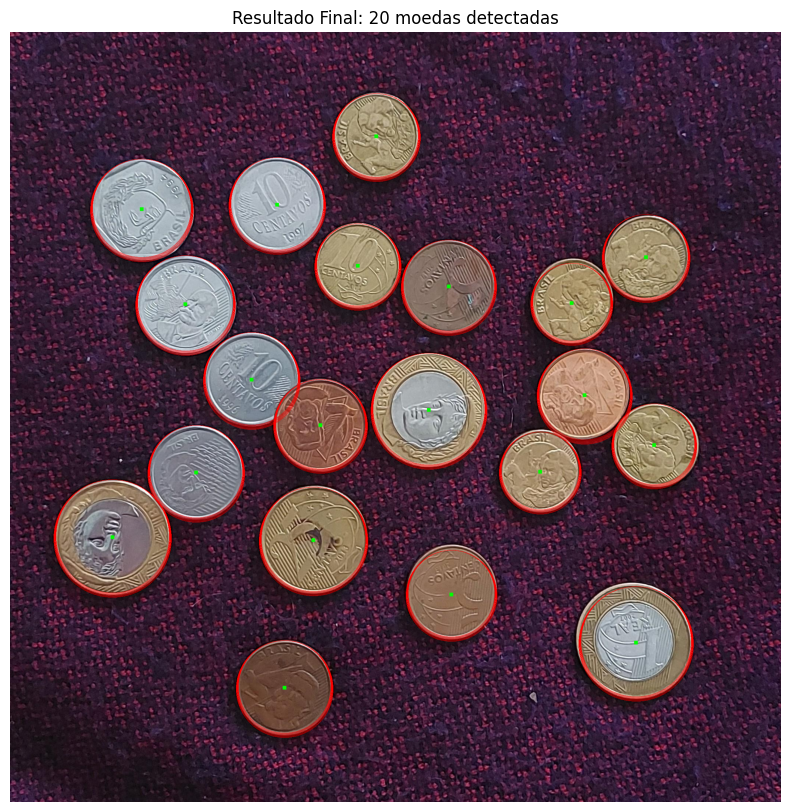

In [1155]:
# --- DESENHANDO O RESULTADO ---

# Cria uma cópia da imagem original para não estragar a variável principal
imagem_resultado = np.copy(imagem_original)

# Loop para desenhar cada moeda encontrada
# zip(cy, cx, raios) junta as listas para processarmos uma moeda por vez
espessura = 3
for centro_y, centro_x, raio in zip(cy, cx, raios):
    for dr in range(-espessura, espessura + 1):
        # circle_perimeter devolve as coordenadas da BORDa do círculo
        circulo_y, circulo_x = circle_perimeter(
            centro_y + dr, centro_x, raio + dr,
            shape=imagem_original.shape
        )
        
        # Pintamos esses pixels de VERMELHO (R=255, G=0, B=0)
        imagem_resultado[circulo_y, circulo_x] = (255, 0, 0)
    
    # Dica extra: Vamos pintar o CENTRO também para ver se ele achou certo
    # Criamos um quadradinho 5x5 no centro
    imagem_resultado[centro_y-5:centro_y+5, centro_x-5:centro_x+5] = (0, 255, 0) # Verde

# Mostra final
plt.figure(figsize=(10, 10))
plt.imshow(imagem_resultado)
plt.title(f"Resultado Final: {len(raios)} moedas detectadas")
plt.axis('off')
plt.show()

In [1156]:
# --- FUNÇÕES MATEMÁTICAS E BASE DE DADOS ---

# Função auxiliar para pegar a cor média de uma máscara
def get_avg_color(mask, img):
    if np.any(mask): # Se a máscara não estiver vazia
        return img[mask].mean(axis=0)
    return np.array([0, 0, 0])

def extrair_caracteristicas_zonais(img, cx, cy, raio):
    """
    Separa a moeda em duas regiões: NÚCLEO (centro) e ANEL (borda).
    Isso é fundamental para identificar a moeda de 1 Real.
    """
    rows, cols = img.shape[:2]
    
    # Cria uma grade de coordenadas (matemática vetorial do NumPy)
    y, x = np.ogrid[:rows, :cols]
    
    # Calcula a distância de cada pixel até o centro (cx, cy)
    dist_from_center = np.sqrt((x - cx)**2 + (y - cy)**2)
    
    # 1. Definir a região do NÚCLEO (0% a 45% do raio)
    mask_nucleo = dist_from_center <= (raio * 0.45)
    
    # 2. Definir a região do ANEL (70% a 85% do raio)
    # Evitamos os 10% finais para não pegar a sombra da mesa
    mask_anel = (dist_from_center > (raio * 0.70)) & (dist_from_center <= (raio * 0.85))

    cor_nucleo = get_avg_color(mask_nucleo, img)
    cor_anel = get_avg_color(mask_anel, img)
        
    # Calcular "Fator de Amarelamento" (Red / Blue)
    # Adicionamos +1 para evitar divisão por zero
    fator_nucleo = cor_nucleo[0] / (cor_nucleo[2] + 1)
    fator_anel = cor_anel[0] / (cor_anel[2] + 1)
    
    return fator_nucleo, fator_anel

def calcular_probabilidade_gaussiana(valor_medido, valor_ideal, tolerancia):
    """
    Retorna uma nota de 0.0 a 1.0 baseada em quão perto o valor está do ideal.
    Usa uma curva de sino (Gaussiana).
    """
    erro = abs(valor_medido - valor_ideal)
    # Fórmula da curva de Gauss
    score = np.exp(- (erro ** 2) / (2 * (tolerancia ** 2)))
    return score

# Mapeamento completo das famílias (1ª e 2ª geração)
# True = Dourada ou Cobre (Vermelha) | False = Prateada (Inox)
DB_MOEDAS = {
    # --- FAMÍLIA ATUAL (2ª) ---
    "1 Real": {
        "valor": 1.00, "raio_ideal": 1.00, 
        "nucleo_gold": False, "anel_gold": True 
    },
    "50 Centavos": {
        "valor": 0.50, "raio_ideal": 0.852, 
        "nucleo_gold": False, "anel_gold": False 
    },
    "25 Centavos (Nova)": {
        "valor": 0.25, "raio_ideal": 0.926, 
        "nucleo_gold": True, "anel_gold": True 
    },
    "10 Centavos (Nova)": {
        "valor": 0.10, "raio_ideal": 0.741, 
        "nucleo_gold": True, "anel_gold": True 
    },
    "5 Centavos (Nova)": {
        "valor": 0.05, "raio_ideal": 0.815, # Colide com 10 antiga
        "nucleo_gold": True, "anel_gold": True # Diferencia pela cor (Cobre entra como Gold)
    },
    
    # --- FAMÍLIA ANTIGA (1ª - 1994/1997) ---
    "25 Centavos (Antiga)": {
        "valor": 0.25, "raio_ideal": 0.870, 
        "nucleo_gold": False, "anel_gold": False 
    },
    "10 Centavos (Antiga)": {
        "valor": 0.10, "raio_ideal": 0.815, # Colide com 5 nova
        "nucleo_gold": False, "anel_gold": False # Diferencia por ser Prata
    },
    "5 Centavos (Antiga)": {
        "valor": 0.05, "raio_ideal": 0.778, 
        "nucleo_gold": False, "anel_gold": False 
    }
}

print("Funções de análise carregadas com sucesso.")

Funções de análise carregadas com sucesso.


--- RELATÓRIO DE INSPEÇÃO ---

MOEDA 1:
   > Raio: 114px (Relativo: 0.73)
   > Cor Núcleo: 1.39 (Dourado)
   > Cor Anel:   1.40   (Dourado)

MOEDA 2:
   > Raio: 154px (Relativo: 0.99)
   > Cor Núcleo: 0.95 (Prata)
   > Cor Anel:   1.40   (Dourado)
   *** ALERTA: Moeda Bimetálica Detectada (Provável 1 Real) ***

MOEDA 3:
   > Raio: 128px (Relativo: 0.82)
   > Cor Núcleo: 0.90 (Prata)
   > Cor Anel:   0.90   (Prata)

MOEDA 4:
   > Raio: 128px (Relativo: 0.82)
   > Cor Núcleo: 1.84 (Dourado)
   > Cor Anel:   1.76   (Dourado)

MOEDA 5:
   > Raio: 126px (Relativo: 0.81)
   > Cor Núcleo: 1.31 (Dourado)
   > Cor Anel:   1.30   (Dourado)

MOEDA 6:
   > Raio: 116px (Relativo: 0.74)
   > Cor Núcleo: 1.40 (Dourado)
   > Cor Anel:   1.40   (Dourado)

MOEDA 7:
   > Raio: 156px (Relativo: 1.00)
   > Cor Núcleo: 0.98 (Prata)
   > Cor Anel:   1.47   (Dourado)
   *** ALERTA: Moeda Bimetálica Detectada (Provável 1 Real) ***

MOEDA 8:
   > Raio: 116px (Relativo: 0.74)
   > Cor Núcleo: 1.44 (Dourado)
   >

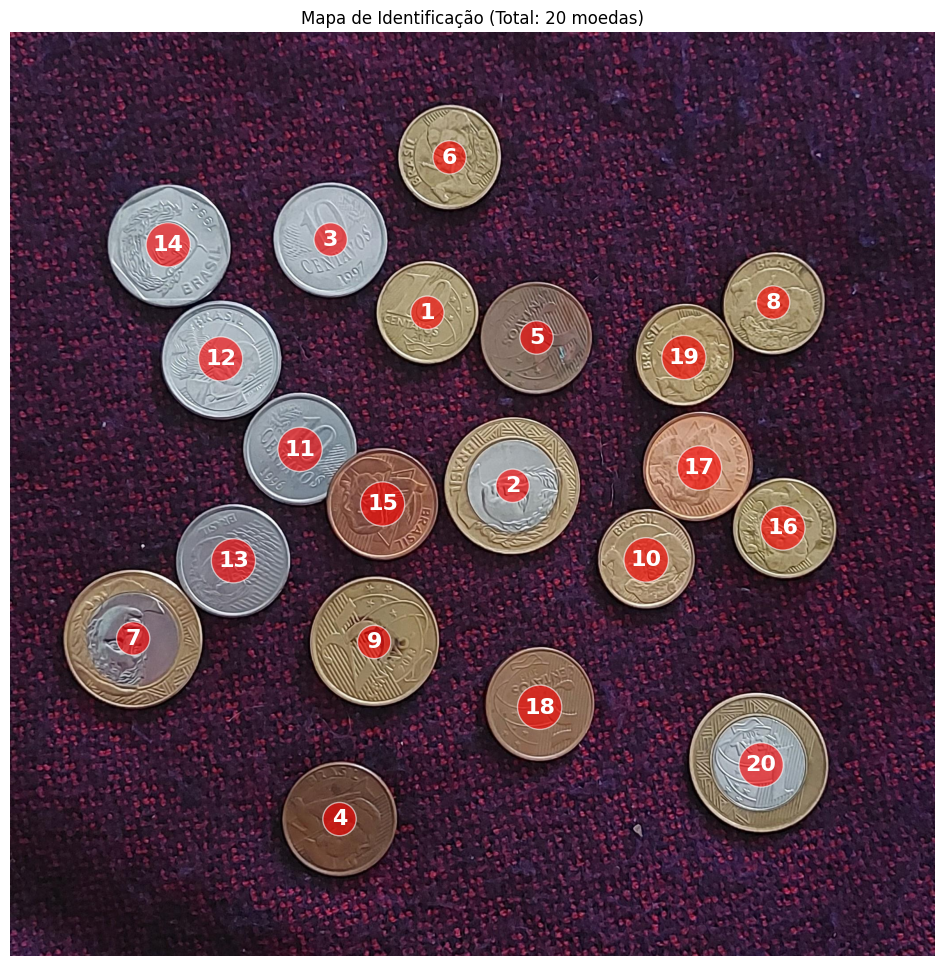

In [1157]:
# --- RELATÓRIO VISUAL DETALHADO (ID + ZONAS) ---

print(f"--- RELATÓRIO DE INSPEÇÃO ---")
raio_referencia = np.max(raios) # A maior moeda define a escala 1.0

# Prepara a imagem para desenhar os números
plt.figure(figsize=(12, 12))
plt.imshow(imagem_original)
plt.title(f"Mapa de Identificação (Total: {len(raios)} moedas)")
plt.axis('off')

# Loop de Análise
for i, (centro_y, centro_x, raio) in enumerate(zip(cy, cx, raios)):
    
    id_moeda = i + 1
    
    fator_nucleo, fator_anel = extrair_caracteristicas_zonais(imagem_original, centro_x, centro_y, raio)
    
    raio_relativo = raio / raio_referencia
    
    # --- Visualização ---
    # Coloca o número ID na moeda
    plt.text(centro_x, centro_y, str(id_moeda), 
             color='white', fontsize=16, fontweight='bold', 
             ha='center', va='center', 
             bbox=dict(facecolor='red', alpha=0.6, edgecolor='white', boxstyle='circle'))

    # --- IMPRESSÃO DOS DADOS ---
    print(f"\nMOEDA {id_moeda}:")
    print(f"   > Raio: {raio:.0f}px (Relativo: {raio_relativo:.2f})")
    
    # Geralmente: < 1.2 é Prata, > 1.3 é Dourado
    tipo_nucleo = "Dourado" if fator_nucleo > 1.25 else "Prata"
    tipo_anel   = "Dourado" if fator_anel   > 1.25 else "Prata"
    
    print(f"   > Cor Núcleo: {fator_nucleo:.2f} ({tipo_nucleo})")
    print(f"   > Cor Anel:   {fator_anel:.2f}   ({tipo_anel})")
    
    if tipo_nucleo != tipo_anel:
        print("   *** ALERTA: Moeda Bimetálica Detectada (Provável 1 Real) ***")

plt.show()

--- RESULTADO FINANCEIRO ---
Moeda 1 analisando...
   -> Classificada como 10 Centavos (Nova) (Confiança: 74.6%)
Moeda 2 analisando...
   -> Classificada como 1 Real (Confiança: 74.4%)
Moeda 3 analisando...
   -> Classificada como 10 Centavos (Antiga) (Confiança: 74.9%)
Moeda 4 analisando...
   -> Classificada como 5 Centavos (Nova) (Confiança: 74.9%)
Moeda 5 analisando...
   -> Classificada como 5 Centavos (Nova) (Confiança: 74.8%)
Moeda 6 analisando...
   -> Classificada como 10 Centavos (Nova) (Confiança: 75.0%)
Moeda 7 analisando...
   -> Classificada como 1 Real (Confiança: 75.0%)
Moeda 8 analisando...
   -> Classificada como 10 Centavos (Nova) (Confiança: 75.0%)
Moeda 9 analisando...
   -> Classificada como 25 Centavos (Nova) (Confiança: 75.0%)
Moeda 10 analisando...
   -> Classificada como 10 Centavos (Nova) (Confiança: 66.5%)
Moeda 11 analisando...
   -> Classificada como 10 Centavos (Antiga) (Confiança: 74.9%)
Moeda 12 analisando...
   -> Classificada como 50 Centavos (Confian

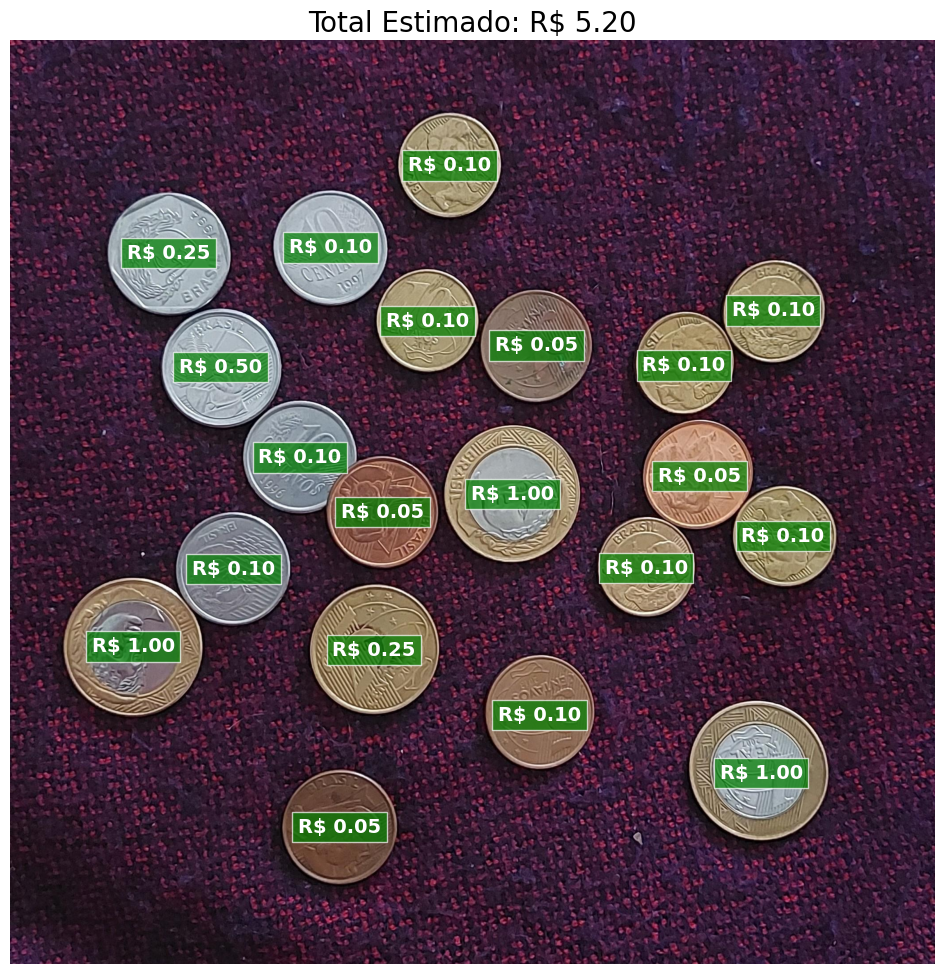


=== SOMA TOTAL: R$ 5.20 ===


In [1158]:
# --- CLASSIFICAÇÃO FINAL E SOMA ---

print(f"--- RESULTADO FINANCEIRO ---")

# Parâmetros de Ajuste (Calibragem)
TOLERANCIA_RAIO = 0.08  # Aceita variação de +/- 8% no tamanho
LIMIAR_GOLD = 1.25      # Ponto de corte entre Prata e Dourado

total_dinheiro = 0.0
imagem_final = np.copy(imagem_original)

plt.figure(figsize=(12, 12))
plt.imshow(imagem_final)
plt.axis('off')

for i, (centro_y, centro_x, raio) in enumerate(zip(cy, cx, raios)):
    
    # 1. Coletar dados
    raio_relativo = raio / raio_referencia
    f_nucleo, f_anel = extrair_caracteristicas_zonais(imagem_final, centro_x, centro_y, raio)
    
    # Transformar cor em booleano (True=Dourado, False=Prata)
    is_nucleo_gold = f_nucleo > LIMIAR_GOLD
    is_anel_gold   = f_anel > LIMIAR_GOLD
    
    # 2. Competição: Quem tem o maior Score?
    melhor_moeda = "Desconhecido"
    maior_score = -1
    valor_detectado = 0.0
    
    print(f"Moeda {i+1} analisando...")
    
    for nome, padrao in DB_MOEDAS.items():
        
        # A. Nota pelo Tamanho (0 a 1)
        score_tamanho = calcular_probabilidade_gaussiana(raio_relativo, padrao['raio_ideal'], TOLERANCIA_RAIO)
        
        # B. Nota pela Cor (0 a 1)
        # Verifica se núcleo bate e se anel bate
        match_nucleo = (padrao['nucleo_gold'] == is_nucleo_gold)
        match_anel   = (padrao['anel_gold']   == is_anel_gold)
        score_cor = (match_nucleo + match_anel) / 2.0 # Média dos acertos
        
        # C. Nota Final Ponderada
        # Tamanho vale 50%, Cor vale 50% (ajuste conforme necessário)
        score_final = (score_tamanho * 0.5) + (score_cor * 0.5)
        
        if score_final > maior_score:
            maior_score = score_final
            melhor_moeda = nome
            valor_detectado = padrao['valor']
    
    # 3. Decisão
    if maior_score > 0.5: # Confiança mínima de 50%
        total_dinheiro += valor_detectado
        texto_label = f"R$ {valor_detectado:.2f}"
        cor_box = 'green'
        print(f"   -> Classificada como {melhor_moeda} (Confiança: {maior_score*100:.1f}%)")
    else:
        texto_label = "?"
        cor_box = 'gray'
        print(f"   -> Não identificada (Confiança baixa: {maior_score*100:.1f}%)")
        
    # Desenhar valor na imagem
    plt.text(centro_x, centro_y, texto_label, 
             color='white', fontsize=14, fontweight='bold', 
             ha='center', va='center', bbox=dict(facecolor=cor_box, alpha=0.7, edgecolor='white'))

plt.title(f"Total Estimado: R$ {total_dinheiro:.2f}", fontsize=20)
plt.show()

print(f"\n=== SOMA TOTAL: R$ {total_dinheiro:.2f} ===")